In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
import pandas as pd

#Replace this source with the local data you have downloaded from our Github
train_path = '/content/drive/MyDrive/Project_C4/df_train.csv'
test_path  = '/content/drive/MyDrive/Project_C4/df_test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)


season_map = {
    "Winter": 1,
    "Spring": 2,
    "Summer": 3,
    "Fall":   4
}

import pandas as pd

df_train["season"] = df_train["season"].map(season_map)
df_test["season"] = df_test["season"].map(season_map)
df_train.head()

,date,trips,median_duration,tavg,prcp,wspd,day_name,day_of_week,is_weekend,season
0,2013-06-01,8691,867,28.1,0.0,17.1,Saturday,5,1,2
1,2013-06-02,15942,813,27.8,0.0,21.1,Sunday,6,1,2
2,2013-06-03,7585,692,23.6,44.6,13.2,Monday,0,0,2
3,2013-06-04,15692,832,20.2,0.0,19.5,Tuesday,1,0,2
4,2013-06-05,15632,797,19.0,0.0,14.2,Wednesday,2,0,2


# Functions

In [9]:
import pandas as pd

#Adds lag and rolling features
def add_lag_rolling_features(df, lag_days=[1,7], rolling_windows=[7,14]):
    df = df.sort_values('date').copy()

    for lag in lag_days:
        df[f'trips_lag{lag}'] = df['trips'].shift(lag)

    for window in rolling_windows:
        df[f'trips_roll{window}'] = df['trips'].shift(1).rolling(window=window).mean()

    df.fillna(0, inplace=True)

    return df


In [10]:
import numpy as np
import pandas as pd

def add_weather_interactions(df):
    df = df.copy()

    #Temperature features
    df["tavg_squared"] = df["tavg"] ** 2
    df["tavg_sqrt"] = np.sqrt(df["tavg"].clip(lower=0))
    df["feels_like"] = df["tavg"] - 0.7 * df["wspd"]
    df["tavg_weekend"] = df["tavg"] * df["is_weekend"]
    df["tavg_dow"] = df["tavg"] * df["day_of_week"]

    #Rain features
    df["log_prcp"] = np.log1p(df["prcp"])
    df["prcp_squared"] = df["prcp"] ** 2
    df["rain_wind"] = df["prcp"] * df["wspd"]
    df["rain_temp"] = df["prcp"] * df["tavg"]
    df["rain_cold"] = df["prcp"] * (df["tavg"] < 10).astype(int)
    df["rain_day"] = (df["prcp"] > 0).astype(int)

    #Wind features
    df["wspd_squared"] = df["wspd"] ** 2
    df["wind_weekend"] = df["wspd"] * df["is_weekend"]
    df["wspd_over_temp"] = df["wspd"] / (df["tavg"] + 1e-6)
    df["wind_rain"] = df["wspd"] * df["prcp"]

    #Comfort features
    df["hot_day"] = (df["tavg"] > 30).astype(int)
    df["cold_day"] = (df["tavg"] < 5).astype(int)
    df["windy_day"] = (df["wspd"] > 25).astype(int)
    df["heavy_rain"] = (df["prcp"] > 10).astype(int)

    df["comfort_score"] = (
        ((df["tavg"] > 15) & (df["tavg"] < 25)).astype(int)
        + (df["wspd"] < 15).astype(int)
        + (df["prcp"] == 0).astype(int)
    )

    #Season features
    if "season" in df:
        df["tavg_season"] = df["tavg"] * df["season"]
        df["prcp_season"] = df["prcp"] * df["season"]
        df["wspd_season"] = df["wspd"] * df["season"]

    #Three column interaction features
    df["temp_wind_rain"] = (df["tavg"] * df["wspd"]) / (df["prcp"] + 1)
    df["temp_wind_weekend"] = df["tavg"] * df["wspd"] * df["is_weekend"]
    df["rain_wind_weekend"] = df["prcp"] * df["wspd"] * df["is_weekend"]

    return df


# Training data from 2013-2017 - Testing on 2018-2019

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet

df = df_train.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

train_df = df[df['year'].between(2013, 2017)]
test_df  = df[df['year'].between(2018, 2019)]

def engineer_features(df):
    df = df.copy()

    #Date features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

    #Cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    #Weather interactions
    df = add_weather_interactions(df)
    #Rolling and lag
    df = add_lag_rolling_features(df, lag_days=[1,7], rolling_windows=[7,14])
    return df

train_df = engineer_features(train_df)
test_df  = engineer_features(test_df)

#Preprocessing
categorical_cols = ['day_name', 'season']

numeric_cols = [
    # Original numeric
    'median_duration', 'tavg', 'prcp', 'wspd',
    'year', 'month', 'day_of_year', 'week_of_year',
    'is_weekend', 'day_of_week',

    # Cyclical
    'month_sin', 'month_cos',
    'dow_sin', 'dow_cos',

    # Simple interactions
    'rain_day',

    # Temperature interactions
    'tavg_squared', 'tavg_sqrt', 'feels_like',
    'tavg_weekend', 'tavg_dow',

    # Precipitation interactions
    'log_prcp', 'prcp_squared',
    'rain_wind', 'rain_temp', 'rain_cold',

    # Wind interactions
    'wspd_squared', 'wind_weekend',
    'wspd_over_temp', 'wind_rain',

    # Comfort indicators
    'hot_day', 'cold_day', 'windy_day', 'heavy_rain',
    'comfort_score',

    # Season interactions
    'tavg_season', 'prcp_season', 'wspd_season',

    # 3-way interactions
    'temp_wind_rain',
    'temp_wind_weekend',
    'rain_wind_weekend',

    # Lagged trips (historical)
    'trips_lag1', 'trips_lag7',

    # Rolling statistics
    'trips_roll7', 'trips_roll14',

]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

Elasticnet

In [12]:
from sklearn.linear_model import ElasticNetCV

elasticnet_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0],
    alphas=[0.01, 0.1, 0.5, 1, 5, 10],
    cv=5,
    max_iter=5000,
    n_jobs=-1
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('elasticnet', elasticnet_cv)
])

X_train = train_df.drop(columns=['trips', 'date'])
y_train = train_df['trips']

X_test  = test_df.drop(columns=['trips', 'date'])
y_test  = test_df['trips']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Metrics
MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

print("ElasticNet Model Results:")
print(f"MAE:  {MAE:,.0f}")
print(f"RMSE: {RMSE:,.0f}")
print(f"R²:   {R2:.3f}")


ElasticNet Model Results:
MAE:  6,727
RMSE: 9,036
R²:   0.813


HGB

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

train_df2 = train_df.copy()
test_df2 = test_df.copy()
for col in ['day_name', 'season']:
    train_df2[col] = train_df2[col].astype('category')
    test_df2[col]  = test_df2[col].astype('category')

X_train = train_df2.drop(columns=['trips', 'date'])
y_train = train_df2['trips']

X_test  = test_df2.drop(columns=['trips', 'date'])
y_test  = test_df2['trips']


hgb = HistGradientBoostingRegressor(random_state=42)

#Hyperparameter tuning
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [20, 50, 100, 200],
    'max_bins': [64, 128, 255]
}

search = RandomizedSearchCV(
    hgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)

#Best model
best_model = search.best_estimator_
print("Best hyperparameters:", search.best_params_)

y_pred = best_model.predict(X_test)

#Metrics
MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

print("HistGradientBoostingRegressor Results (Tuned, No Preprocessing):")
print(f"MAE:  {MAE:,.0f}")
print(f"RMSE: {RMSE:,.0f}")
print(f"R²:   {R2:.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

Catboost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

catboost_base = CatBoostRegressor(
    eval_metric='RMSE',
    random_seed=42,
    verbose=0
)

param_grid = {
    'iterations': [500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3]
}

grid_search = GridSearchCV(
    estimator=catboost_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('catboost', grid_search)
])

X_train = train_df.drop(columns=['trips', 'date'])
y_train = train_df['trips']

X_test  = test_df.drop(columns=['trips', 'date'])
y_test  = test_df['trips']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

print("CatBoost GridSearchCV Results:")
print(f"MAE:  {MAE:,.0f}")
print(f"RMSE: {RMSE:,.0f}")
print(f"R²:   {R2:.3f}")
print("Best parameters:", model.named_steps['catboost'].best_params_)


CatBoost GridSearchCV Results:
MAE:  23,469
RMSE: 29,771
R²:   0.212
Best parameters: {'depth': 4, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.05}


LassoCV

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lasso_cv = LassoCV(
    alphas=[0.01, 0.1, 1, 5, 10],
    cv=5,
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('lasso', lasso_cv)
])

X_train = train_df.drop(columns=['trips', 'date'])
y_train = train_df['trips']

X_test = test_df.drop(columns=['trips', 'date'])
y_test = test_df['trips']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("Lasso Regression Results:")
print(f"MAE:  {MAE:,.0f}")
print(f"RMSE: {RMSE:,.0f}")
print(f"R²:   {R2:.3f}")
print("Best alpha:", model.named_steps['lasso'].alpha_)


Lasso Regression Results:
MAE:  13,188
RMSE: 17,346
R²:   0.732
Best alpha: 10.0


RidgeCV

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

ridge_cv = RidgeCV(
    alphas=[0.01, 0.1, 1, 5, 10],
    cv=5,
    scoring='neg_mean_squared_error'
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('ridge', ridge_cv)
])

X_train = train_df.drop(columns=['trips', 'date'])
y_train = train_df['trips']

X_test = test_df.drop(columns=['trips', 'date'])
y_test = test_df['trips']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("Ridge Regression Results:")
print(f"MAE:  {MAE:,.0f}")
print(f"RMSE: {RMSE:,.0f}")
print(f"R²:   {R2:.3f}")
print("Best alpha:", model.named_steps['ridge'].alpha_)


Ridge Regression Results:
MAE:  13,181
RMSE: 17,313
R²:   0.733
Best alpha: 10.0


MLP Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

mlp = MLPRegressor(max_iter=2000, random_state=42)

param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,)],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.0001],
    'mlp__learning_rate_init': [ 0.01]
}

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('mlp', mlp)
])

grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
X_train = train_df.drop(columns=['trips', 'date'])
y_train = train_df['trips']
X_test = test_df.drop(columns=['trips', 'date'])
y_test = test_df['trips']

grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("MLP Regression Results:")
print(f"MAE:  {MAE:,.0f}")
print(f"RMSE: {RMSE:,.0f}")
print(f"R²:   {R2:.3f}")
print("Best params:", grid_search.best_params_)


MLP Regression Results:
MAE:  18,606
RMSE: 23,363
R²:   0.515
Best params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.01}


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


# Training data 2013-2019, Testing on 2020-2023 (Lockdown excluded)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
df = df_train.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

train_df = df
test_df  = df_test.copy()
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year

lockdown_start = pd.to_datetime('2020-03-22')
lockdown_end   = pd.to_datetime('2020-04-10')
test_df = test_df[~((test_df['date'] >= lockdown_start) & (test_df['date'] <= lockdown_end))]

def engineer_features(df):
    df = df.copy()
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df = add_weather_interactions(df)
    df = add_lag_rolling_features(df, lag_days=[1,7], rolling_windows=[7,14])
    return df

train_df = engineer_features(train_df)
test_df  = engineer_features(test_df)

categorical_cols = ['day_name', 'season']

numeric_cols = [
    'median_duration', 'tavg', 'prcp', 'wspd',
    'year', 'month', 'day_of_year', 'week_of_year',
    'is_weekend', 'day_of_week',
    'month_sin', 'month_cos',
    'dow_sin', 'dow_cos',
    'rain_day',
    'tavg_squared', 'tavg_sqrt', 'feels_like',
    'tavg_weekend', 'tavg_dow',
    'log_prcp', 'prcp_squared',
    'rain_wind', 'rain_temp', 'rain_cold',
    'wspd_squared', 'wind_weekend',
    'wspd_over_temp', 'wind_rain',
    'hot_day', 'cold_day', 'windy_day', 'heavy_rain',
    'comfort_score',
    'tavg_season', 'prcp_season', 'wspd_season',
    'temp_wind_rain',
    'temp_wind_weekend',
    'rain_wind_weekend',
    'trips_lag1', 'trips_lag7',
    'trips_roll7', 'trips_roll14'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)


ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNetCV

elasticnet_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0],
    alphas=[0.01, 0.1, 0.5, 1, 5, 10],
    cv=5,
    max_iter=5000,
    n_jobs=-1
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('elasticnet', elasticnet_cv)
])

X_train = train_df.drop(columns=['trips', 'date'])
y_train = train_df['trips']

X_test  = test_df.drop(columns=['trips', 'date'])
y_test  = test_df['trips']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Metrics
MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

print("ElasticNet Model Results:")
print(f"MAE:  {MAE:,.0f}")
print(f"RMSE: {RMSE:,.0f}")
print(f"R²:   {R2:.3f}")

ElasticNet Model Results:
MAE:  13,180
RMSE: 17,177
R²:   0.738


HGB

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

train_df2 = train_df.copy()
test_df2 = test_df.copy()
for col in ['day_name', 'season']:
    train_df2[col] = train_df2[col].astype('category')
    test_df2[col]  = test_df2[col].astype('category')

X_train = train_df2.drop(columns=['trips', 'date'])
y_train = train_df2['trips']

X_test  = test_df2.drop(columns=['trips', 'date'])
y_test  = test_df2['trips']


hgb = HistGradientBoostingRegressor(random_state=42)

#Hyperparameter tuning
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [20, 50, 100, 200],
    'max_bins': [64, 128, 255]
}

search = RandomizedSearchCV(
    hgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)

#Best model
best_model = search.best_estimator_
print("Best hyperparameters:", search.best_params_)

y_pred = best_model.predict(X_test)

#Metrics
MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)

print("HistGradientBoostingRegressor Results (Tuned, No Preprocessing):")
print(f"MAE:  {MAE:,.0f}")
print(f"RMSE: {RMSE:,.0f}")
print(f"R²:   {R2:.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'min_samples_leaf': 50, 'max_iter': 500, 'max_depth': 3, 'max_bins': 128, 'learning_rate': 0.05}
HistGradientBoostingRegressor Results (Tuned, No Preprocessing):
MAE:  24,611
RMSE: 31,366
R²:   0.125


RidgeCV

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

ridge_cv = RidgeCV(
    alphas=[0.01, 0.1, 1, 5, 10],
    cv=5,
    scoring='neg_mean_squared_error'
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('ridge', ridge_cv)
])

X_train = train_df.drop(columns=['trips', 'date'])
y_train = train_df['trips']

X_test = test_df.drop(columns=['trips', 'date'])
y_test = test_df['trips']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("Ridge Regression Results:")
print(f"MAE:  {MAE:,.0f}")
print(f"RMSE: {RMSE:,.0f}")
print(f"R²:   {R2:.3f}")
print("Best alpha:", model.named_steps['ridge'].alpha_)


Ridge Regression Results:
MAE:  13,181
RMSE: 17,313
R²:   0.733
Best alpha: 10.0


LassoCV

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lasso_cv = LassoCV(
    alphas=[0.01, 0.1, 1, 5, 10],
    cv=5,
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('lasso', lasso_cv)
])

X_train = train_df.drop(columns=['trips', 'date'])
y_train = train_df['trips']

X_test = test_df.drop(columns=['trips', 'date'])
y_test = test_df['trips']

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("Lasso Regression Results:")
print(f"MAE:  {MAE:,.0f}")
print(f"RMSE: {RMSE:,.0f}")
print(f"R²:   {R2:.3f}")
print("Best alpha:", model.named_steps['lasso'].alpha_)


Lasso Regression Results:
MAE:  13,188
RMSE: 17,346
R²:   0.732
Best alpha: 10.0


Plotting prediction accuracy

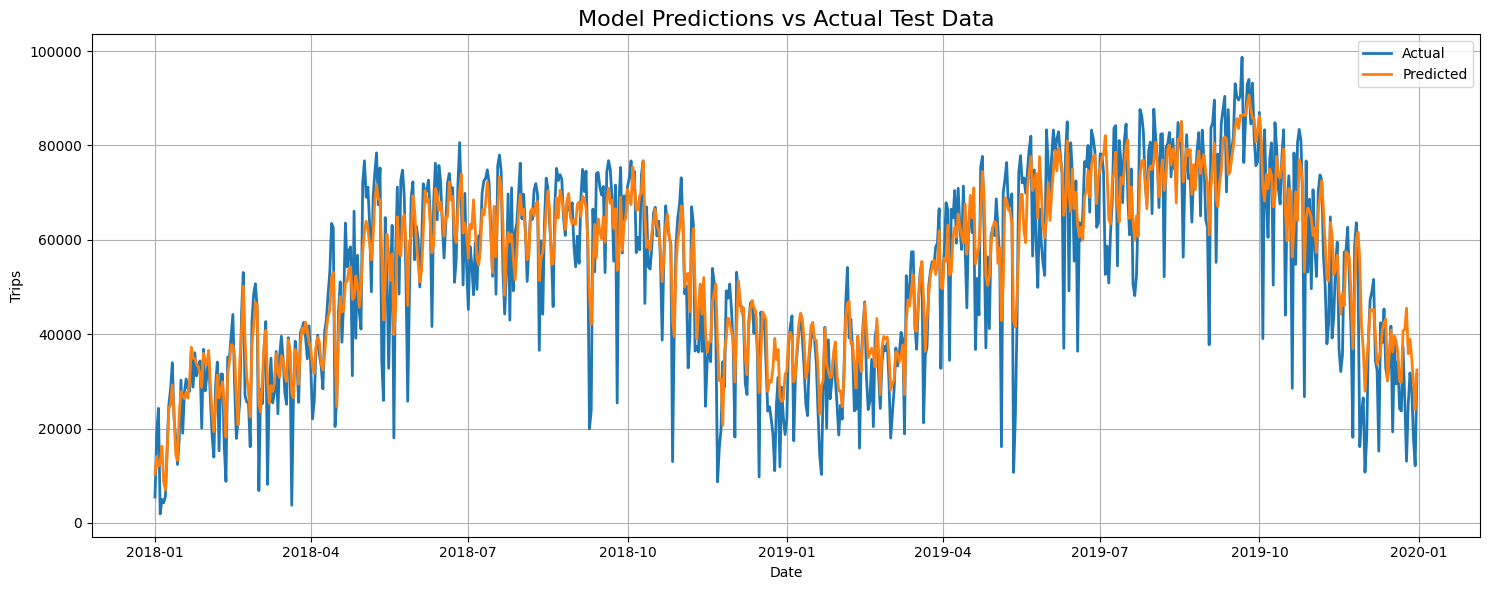

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plot_df = pd.DataFrame({
    'date': test_df['date'],
    'Actual Trips': y_test.values,
    'Predicted Trips': y_pred
}).set_index('date')

plt.figure(figsize=(15,6))
plt.plot(plot_df.index, plot_df['Actual Trips'], label='Actual', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted Trips'], label='Predicted', linewidth=2)

plt.title("Model Predictions vs Actual Test Data", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ChatGPT was used for inspiration and troubleshooting.